In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Setup

## Imports

In [2]:
import pandas as pd
import tensorflow as tf
import numpy as np
import os
import pathlib
import matplotlib.pyplot as plt
import matplotlib
from tensorflow.keras import layers

## formatting

In [3]:
float_formatter = "{:.5f}".format
np.set_printoptions(formatter={'float_kind':float_formatter})

plt.style.use('default')
%matplotlib inline

matplotlib.rcParams.update({'font.size': 10})

## Paths and directories

In [136]:
ROOT_DIR = pathlib.Path("/content/drive/MyDrive/Research/PAPER_1_CODE")
DATA_DIR = ROOT_DIR/"PVS"

train_dir = DATA_DIR/"TRAIN"
valid_dir = DATA_DIR/"VALID"
test_dir = DATA_DIR/"TEST"

model_save_root = ROOT_DIR/"models"

Import custom modules

In [5]:
import importlib.util
import sys
from pathlib import Path

# Set the full path to the parent directory of the package
parent_path = '/content/drive/MyDrive/Research/PAPER_1_CODE/pkg'

# Add the parent directory to the system path
sys.path.append(parent_path)

# Import the package (and execute __init__.py)
from pv_analysis.cardiovascular_data import CardiovascularData
from pv_analysis.pv_analyst import PV_Analyst

# Load DS and check it out!

## DS pre-processing functions

In [6]:
@tf.function()
def rand_pv(pv):
  """ randomized pv """
  def apply_rand(pv):
    ps = pv[:, 0]
    vs = pv[:, 1]
    rand_y_translate = np.random.uniform(-0.14, 0.05) # [0.01, 0.20] -> starts at 0.15
    ps += rand_y_translate
    ps = ps.reshape((-1,1))
    vs = vs.reshape((-1,1))
    return np.hstack((ps, vs))
  return tf.numpy_function(apply_rand, [pv], tf.float32)

@tf.function()
def adjust_pressure(pv):
  """ prevents negative pressure after rendomization """
  def fun(pv):
    ps = pv[:, 0]
    min_p = np.min(ps)
    if min_p < 0:
      pv[:, 0] -= min_p
    return pv
  return tf.numpy_function(fun, [pv], tf.float32)

@tf.function()
def match_initial_and_final_states(pv):
  """ set last data equal to inital value """
  def apply_mod(pv):
    pv = np.vstack((pv, pv[0]))
    return pv
  return tf.numpy_function(apply_mod, [pv], tf.float32)

@tf.function()
def rand_pv_and_match_boundary_states(pv):
  pv = rand_pv(pv)
  pv = adjust_pressure(pv)
  pv = match_initial_and_final_states(pv)
  return pv

@tf.function()
def process_for_ae(pv):
  pv = rand_pv_and_match_boundary_states(pv)
  return pv, pv

In [7]:
from functools import partial
def process_pv_ds(ref_ds):
  ds = ref_ds.map(process_for_ae)
  return ds

## load DS

In [8]:
def load_ds(p):
  return tf.data.experimental.load(str(p))

ds_train = process_pv_ds(load_ds(train_dir))
ds_valid = process_pv_ds(load_ds(valid_dir))
ds_test = process_pv_ds(load_ds(test_dir))

Instructions for updating:
Use `tf.data.Dataset.load(...)` instead.
Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


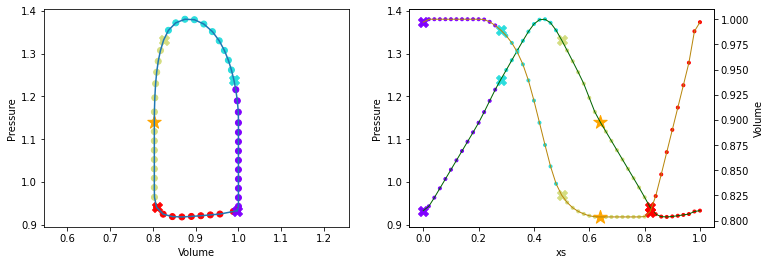

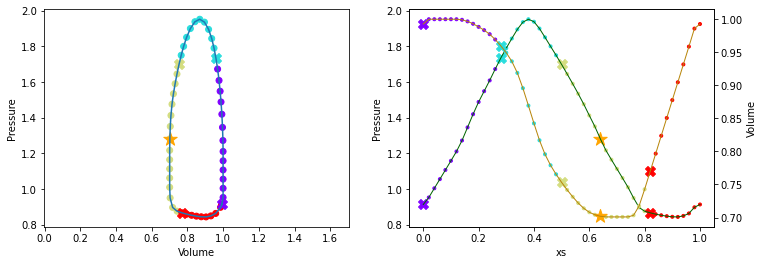

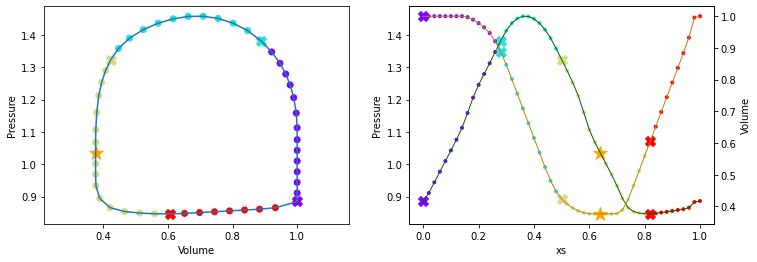

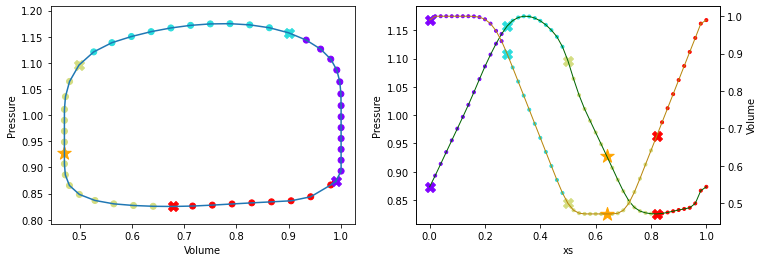

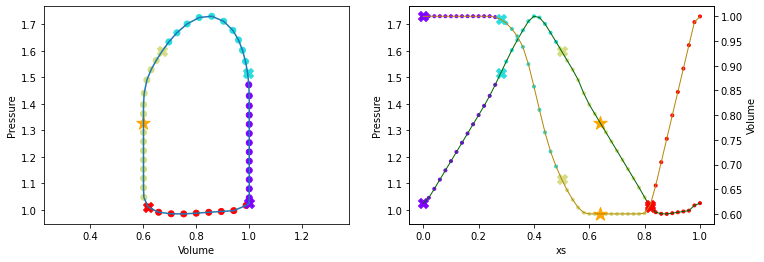

In [9]:
PVA = PV_Analyst()
for sample_pv, _ in ds_train.take(5):
  PVA.plot_pv(pv=sample_pv, color_mask="phases", legend=False,
              expanded_plot=True, pvl=True, equal=True, figsize=(12,4))

## set ds for performance

In [10]:
def set_ds_for_performance(ds, batch_size=100, prefetch_buffer_size=1, shuffle_buffer_size=30):
  ds = ds.cache()
  if shuffle_buffer_size > 0:
    ds = ds.shuffle(shuffle_buffer_size)
  ds = ds.batch(batch_size).prefetch(prefetch_buffer_size)
  return ds

In [11]:
ds_train = set_ds_for_performance(ds_train, 64, shuffle_buffer_size=128)
ds_valid = set_ds_for_performance(ds_valid, 64, shuffle_buffer_size=128)
ds_test = set_ds_for_performance(ds_test, 32, shuffle_buffer_size=128)

# Build model

## Normalization Layers

In [12]:
def get_ds_for_normalization(ds, batch_size=800):
  norm_ds = ds.map(lambda x, y: x)
  norm_ds = norm_ds.unbatch()
  norm_ds = norm_ds.shuffle(batch_size)
  norm_ds = norm_ds.batch(batch_size)
  norm_ds = norm_ds.prefetch(1)
  return norm_ds 

In [13]:
from tensorflow.keras.layers.experimental import preprocessing
pv_norm_ds = get_ds_for_normalization(ds_train)

PV_NormLayer = preprocessing.Normalization()
for xs in pv_norm_ds.take(1):
  PV_NormLayer.adapt(xs)

## PV model

In [14]:
from tensorflow.keras.layers import Flatten, Dense, ActivityRegularization
from tensorflow.keras.layers import Conv1D, MaxPool1D, GaussianNoise
from tensorflow.keras.layers import Lambda

In [15]:
PV_LEN = sample_pv.shape[0]
PV_LEN

51

In [33]:
N_CODINGS = 20

#### Encoder

In [34]:
# inputs
pv_in = layers.Input([PV_LEN, 2], name="pv_in")
# normalize inputs
pv_norm = PV_NormLayer(pv_in)
# add noise for training
# pv_noise = GaussianNoise(0.0001)(pv_norm)
# process convulution
pv_process_conv = tf.keras.Sequential([
  layers.Input([PV_LEN, 2], name="convs_in"),
  Conv1D(32, 5, 1),
  Conv1D(16, 3, 1),
  Conv1D(2, 3, 1),
  # Conv1D(8, 3, 1, padding="same"),
  # MaxPool1D(5),
  # Conv1D(64, 5, 1),
  # Conv1D(64, 3, 1),
  # MaxPool1D(3),
  # Conv1D(64, 3, 1, padding="valid"),
  # MaxPool1D(2),
  # Conv1D(16, 3, 1, padding="valid"),
  # MaxPool1D(2, 1, padding="same"),
  ], name="pv_process_conv")
pv_convs = pv_process_conv(pv_norm)
# process codings
pv_codings = Flatten(name="flat_convs")(pv_convs)

pv_process_codings = tf.keras.Sequential([
  # Dense(16, activation="selu"),
  Dense(N_CODINGS, activation="tanh"),
  # Dense(N_CODINGS, activation="softmax"),

  ], name="pv_process_codings")
pv_codings = pv_process_codings(pv_codings)

pv_codings = ActivityRegularization(0.001125, 0.0029)(pv_codings)
# create encoder
PV_ENCODER = tf.keras.Model(
    inputs=pv_in, 
    outputs=pv_codings, 
    name="PV_ENCODER"
    )
PV_ENCODER.summary()

Model: "PV_ENCODER"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 pv_in (InputLayer)          [(None, 51, 2)]           0         
                                                                 
 normalization (Normalizatio  (None, 51, 2)            5         
 n)                                                              
                                                                 
 pv_process_conv (Sequential  (None, 43, 2)            2002      
 )                                                               
                                                                 
 flat_convs (Flatten)        (None, 86)                0         
                                                                 
 pv_process_codings (Sequent  (None, 20)               1740      
 ial)                                                            
                                                        

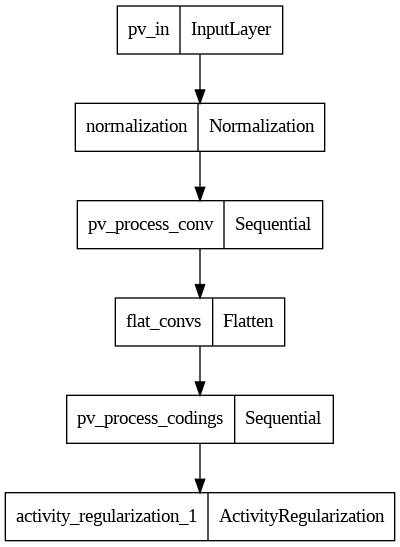

In [35]:
tf.keras.utils.plot_model(PV_ENCODER)

#### Decoder

In [36]:
# process info
N_FO_UNITS = 30
DROPOUT_RATE = 0.2

codings_in = layers.Input([N_CODINGS], name="codings_in")

ps_out = tf.keras.Sequential([
  # Dense(N_FO_UNITS, activation="tanh"),
  # Dropout(DROPOUT_RATE),
  # Dense(N_FO_UNITS, activation="relu"),
  # Dropout(DROPOUT_RATE),
  # Dense(N_FO_UNITS, activation="relu"),
  # Dropout(DROPOUT_RATE),
  Dense(PV_LEN),
  ], name="ps_out")

vs_out = tf.keras.Sequential([
  # Dense(N_FO_UNITS, activation="tanh"),
  # Dropout(DROPOUT_RATE),
  # Dense(N_FO_UNITS, activation="relu"),
  # Dropout(DROPOUT_RATE),
  # Dense(N_FO_UNITS, activation="relu"),
  # Dropout(DROPOUT_RATE),
  Dense(PV_LEN),
  ], name="vs_out")

# de_codings = codings_in(pv_norm)
ps = ps_out(codings_in)
vs = vs_out(codings_in)
# concat ps and vs
pv_concat = Lambda(lambda x: tf.stack(x, -1), name="pv_concat")([ps, vs]) 

de_process_pv = tf.keras.Sequential([
  # Conv1D(16, 3, padding="SAME"),
  Conv1D(2, 3, padding="SAME"),
  ], name="de_process_pv")
pv_out = de_process_pv(pv_concat)


# pv_out = ActivityRegularization(0.001, 0.001)(pv_out)
# create decoder
PV_DECODER = tf.keras.Model(
    inputs=codings_in, 
    outputs=pv_out, 
    name="PV_DECODER"
    )
PV_DECODER.summary()

Model: "PV_DECODER"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 codings_in (InputLayer)        [(None, 20)]         0           []                               
                                                                                                  
 ps_out (Sequential)            (None, 51)           1071        ['codings_in[0][0]']             
                                                                                                  
 vs_out (Sequential)            (None, 51)           1071        ['codings_in[0][0]']             
                                                                                                  
 pv_concat (Lambda)             (None, 51, 2)        0           ['ps_out[0][0]',                 
                                                                  'vs_out[0][0]']        

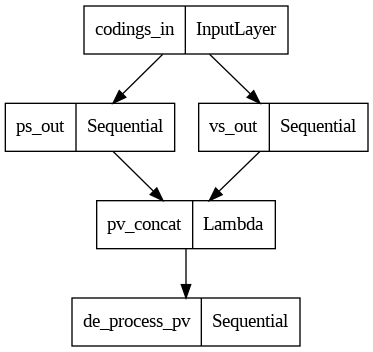

In [37]:
tf.keras.utils.plot_model(PV_DECODER)

#### Autoencoder


In [38]:
# create autoencoder
ae_in = layers.Input([PV_LEN, 2], name="ae_in")
ae_cods = PV_ENCODER(ae_in)
ae_out = PV_DECODER(ae_cods)

PV_AUTOENCODER = tf.keras.Model(
    inputs=ae_in, 
    outputs=ae_out, 
    name="PV_AUTOENCODER"
    )
PV_AUTOENCODER.summary()

Model: "PV_AUTOENCODER"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 ae_in (InputLayer)          [(None, 51, 2)]           0         
                                                                 
 PV_ENCODER (Functional)     (None, 20)                3747      
                                                                 
 PV_DECODER (Functional)     (None, 51, 2)             2156      
                                                                 
Total params: 5,903
Trainable params: 5,898
Non-trainable params: 5
_________________________________________________________________


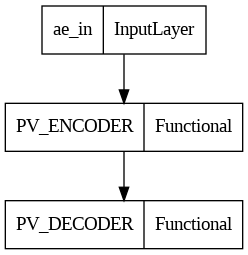

In [39]:
tf.keras.utils.plot_model(PV_AUTOENCODER)

# Train

In [40]:
PVAE_Optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
PVAE_Loss = [tf.keras.losses.MeanSquaredError(), tf.keras.losses.Huber()]
PVAE_Loss_weights = [0.8, 0.2]

# PVAE_Loss = tf.keras.losses.MeanSquaredError()

PV_AUTOENCODER.compile(
    loss = PVAE_Loss,
    loss_weights=PVAE_Loss_weights,
    optimizer=PVAE_Optimizer,
    metrics=["mse", "mae"]
)

PVAE_Callbacks = [
  tf.keras.callbacks.ReduceLROnPlateau(factor=0.9, patience=10, verbose=1),
  tf.keras.callbacks.EarlyStopping(patience=15, verbose=1, restore_best_weights=True),
]

In [41]:
with tf.device('/device:GPU:0'):
  PVE_TrainHistory = PV_AUTOENCODER.fit(
    ds_train,
    epochs=500, verbose=1, 
    validation_data=ds_valid,
    callbacks=PVAE_Callbacks
  )

Epoch 1/500
110/110 [==============================] - 5s 13ms/step - loss: 0.8067 - mse: 1.0010 - mae: 0.9451 - val_loss: 0.7717 - val_mse: 0.9588 - val_mae: 0.9209 - lr: 1.0000e-04
Epoch 2/500
110/110 [==============================] - 1s 9ms/step - loss: 0.7482 - mse: 0.9284 - mae: 0.8927 - val_loss: 0.7223 - val_mse: 0.8948 - val_mae: 0.8596 - lr: 1.0000e-04
Epoch 3/500
110/110 [==============================] - 1s 9ms/step - loss: 0.6979 - mse: 0.8628 - mae: 0.8274 - val_loss: 0.6718 - val_mse: 0.8286 - val_mae: 0.7926 - lr: 1.0000e-04
Epoch 4/500
110/110 [==============================] - 1s 12ms/step - loss: 0.6467 - mse: 0.7956 - mae: 0.7605 - val_loss: 0.6203 - val_mse: 0.7608 - val_mae: 0.7262 - lr: 1.0000e-04
Epoch 5/500
110/110 [==============================] - 2s 15ms/step - loss: 0.5947 - mse: 0.7263 - mae: 0.6943 - val_loss: 0.5668 - val_mse: 0.6883 - val_mae: 0.6617 - lr: 1.0000e-04
Epoch 6/500
110/110 [==============================] - 1s 13ms/step - loss: 0.5315 - ms

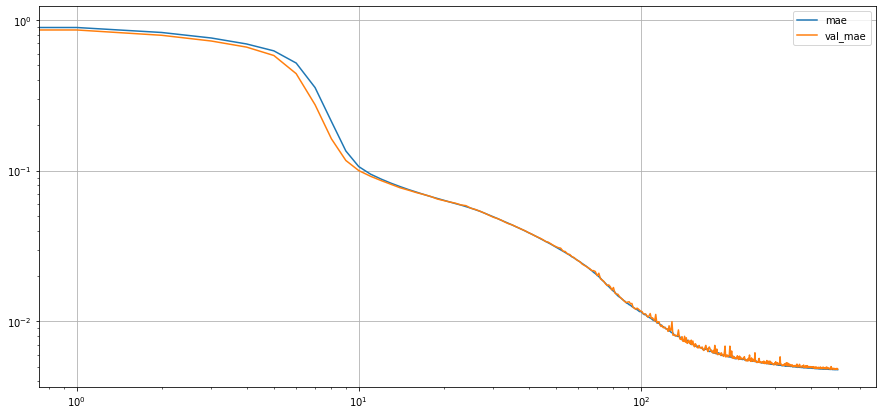

In [42]:
trainHist_df = pd.DataFrame(PVE_TrainHistory.history)
trainHist_df.plot(y=["mae", "val_mae"], 
                  figsize=(15,7), logx=True, logy=True)
plt.grid(True)
plt.show()

# Evaluate

In [43]:
PV_AUTOENCODER.evaluate(ds_test)

47/47 [==============================] - 0s 6ms/step - loss: 2.0674e-04 - mse: 4.9721e-05 - mae: 0.0049


[0.00020673724066000432, 4.972118404111825e-05, 0.004895614460110664]

In [44]:
PV_AUTOENCODER.evaluate(ds_test)

47/47 [==============================] - 0s 6ms/step - loss: 2.0674e-04 - mse: 4.9721e-05 - mae: 0.0049


[0.0002067372261080891, 4.9721191317075863e-05, 0.00489561352878809]

In [45]:
trainHist_df.to_csv

<bound method NDFrame.to_csv of          loss       mse       mae  val_loss   val_mse   val_mae        lr
0    0.806708  1.000980  0.945063  0.771668  0.958795  0.920933  0.000100
1    0.748212  0.928378  0.892735  0.722301  0.894792  0.859643  0.000100
2    0.697940  0.862837  0.827389  0.671753  0.828552  0.792645  0.000100
3    0.646747  0.795627  0.760474  0.620329  0.760759  0.726219  0.000100
4    0.594716  0.726311  0.694317  0.566817  0.688313  0.661716  0.000100
..        ...       ...       ...       ...       ...       ...       ...
495  0.000201  0.000047  0.004793  0.000206  0.000048  0.004832  0.000002
496  0.000201  0.000047  0.004792  0.000206  0.000049  0.004882  0.000002
497  0.000201  0.000047  0.004789  0.000206  0.000049  0.004874  0.000002
498  0.000201  0.000047  0.004787  0.000206  0.000048  0.004831  0.000002
499  0.000201  0.000047  0.004786  0.000206  0.000049  0.004842  0.000002

[500 rows x 7 columns]>

# Visualize

1/1 [==============================] - 0s 22ms/step


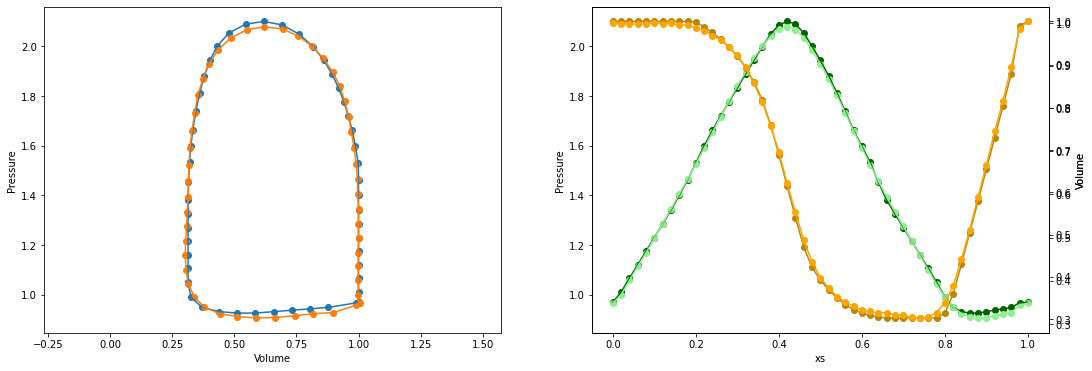

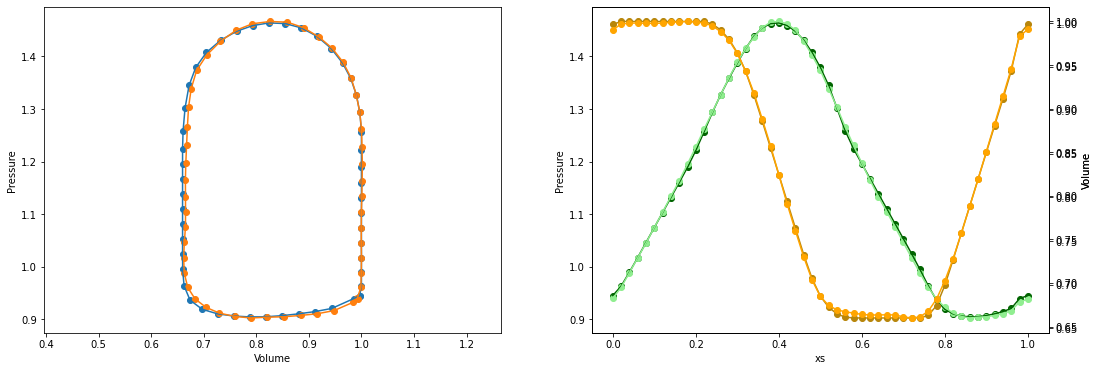

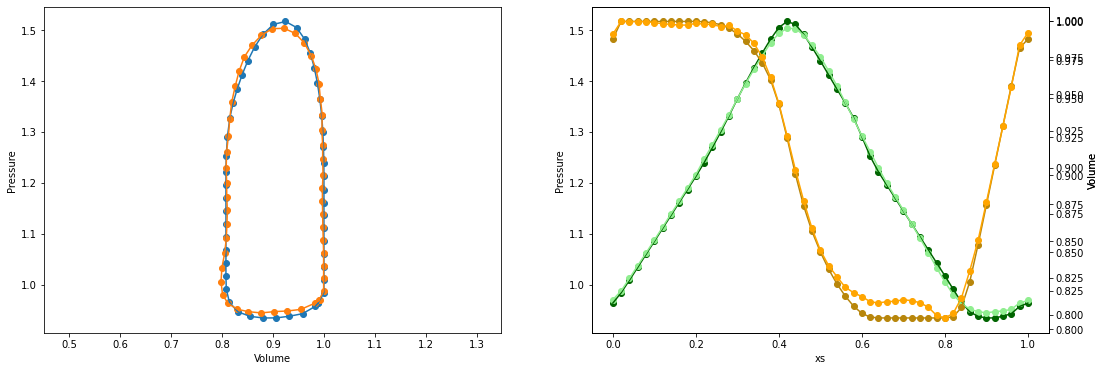

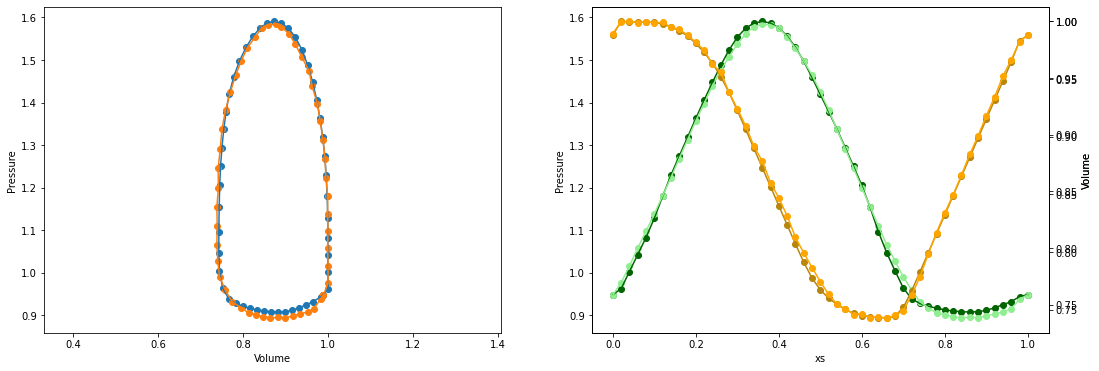

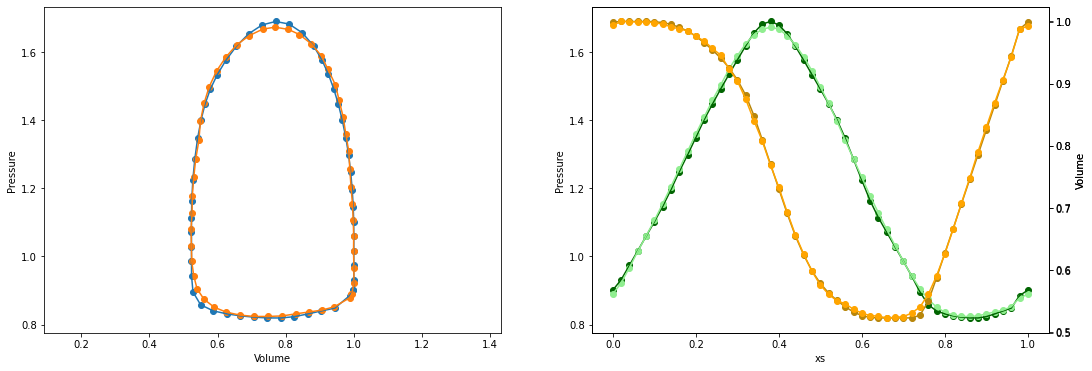

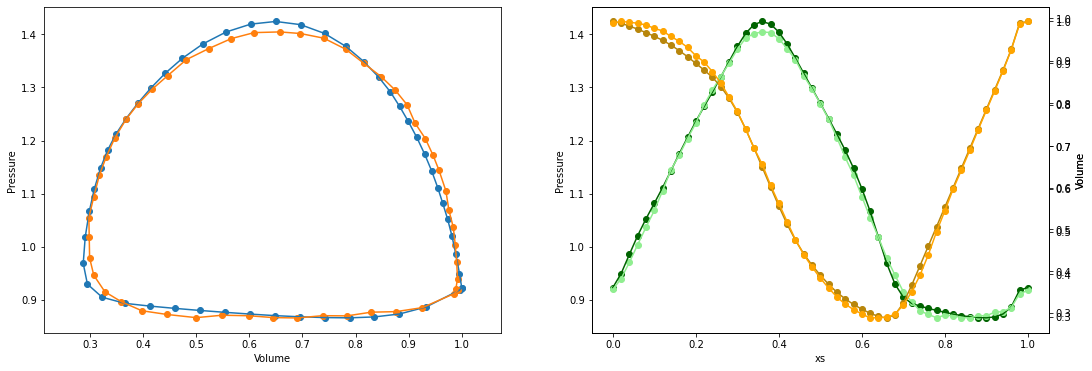

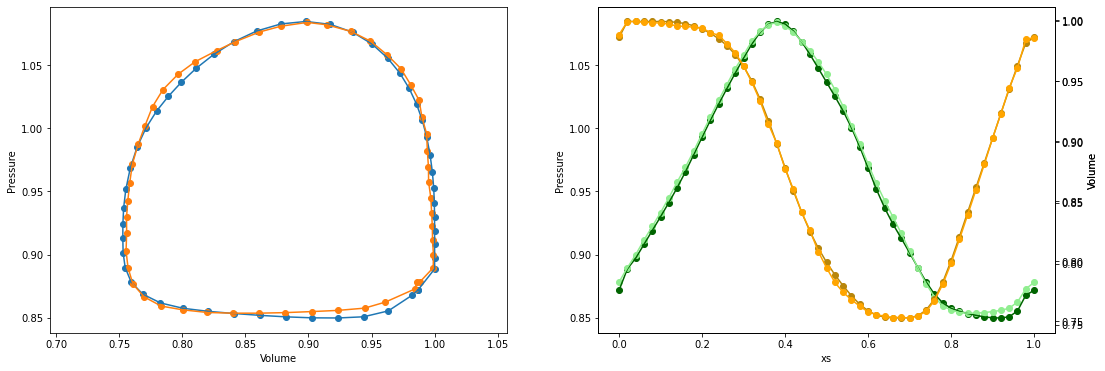

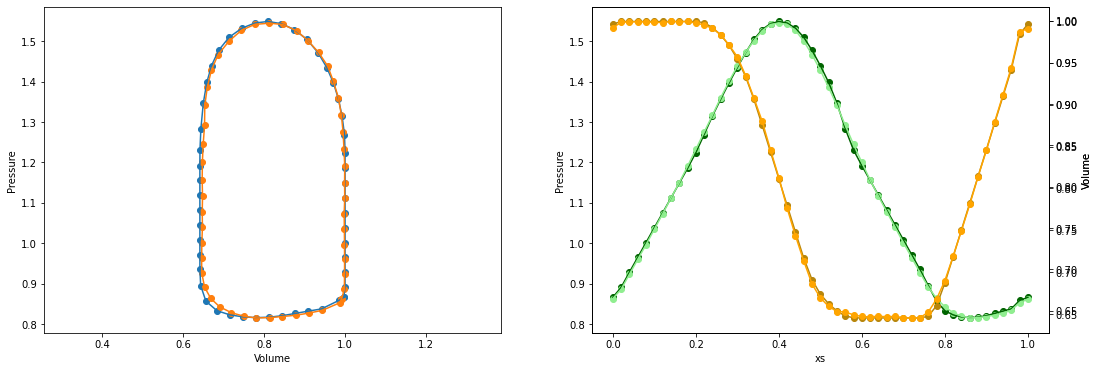

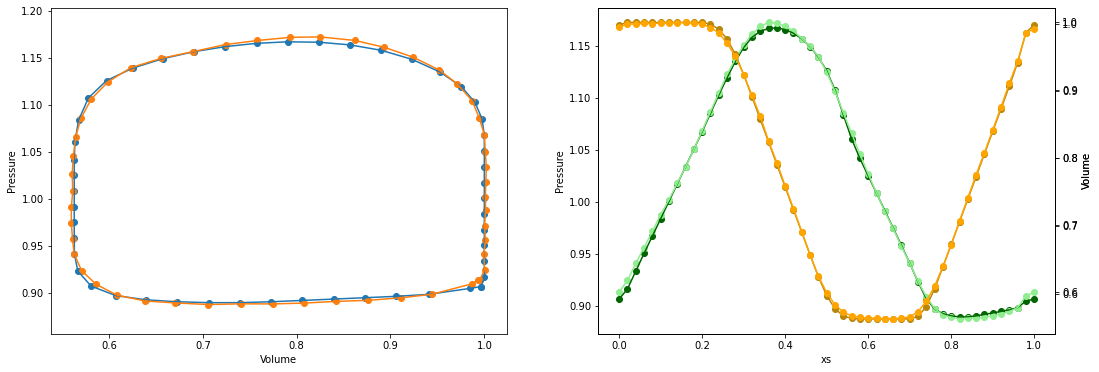

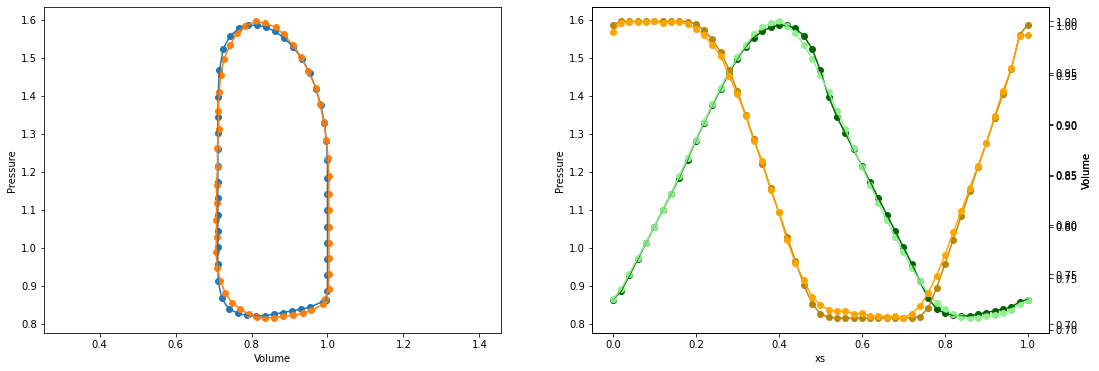

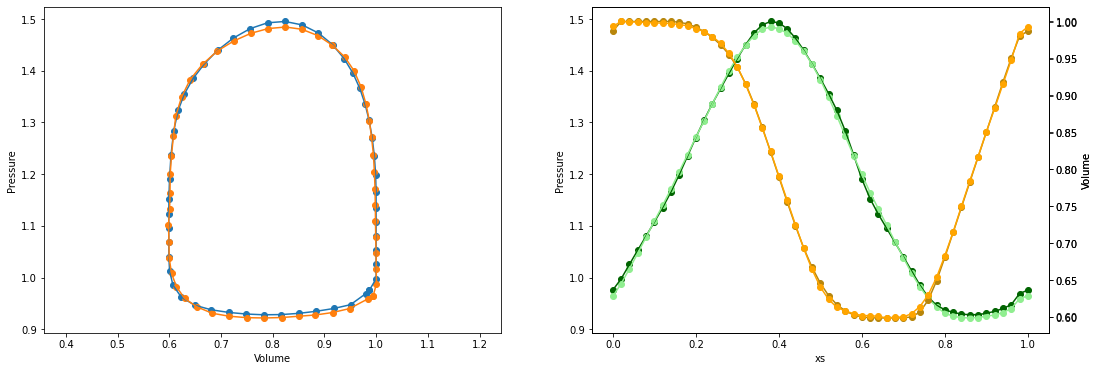

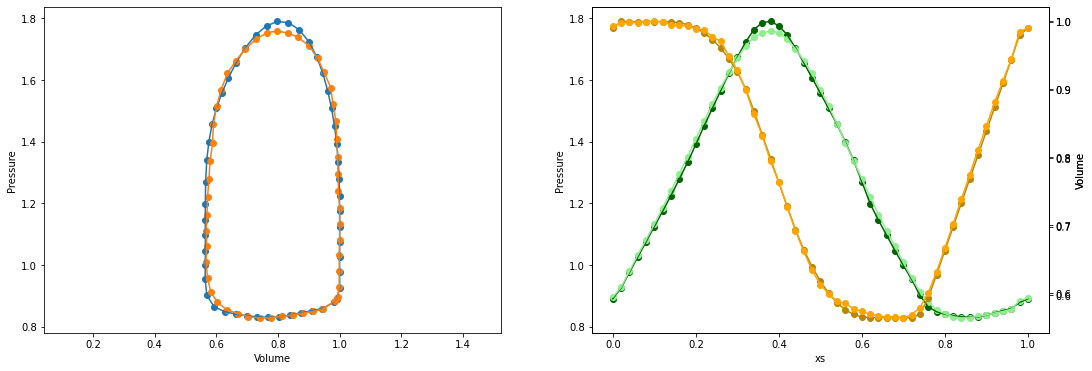

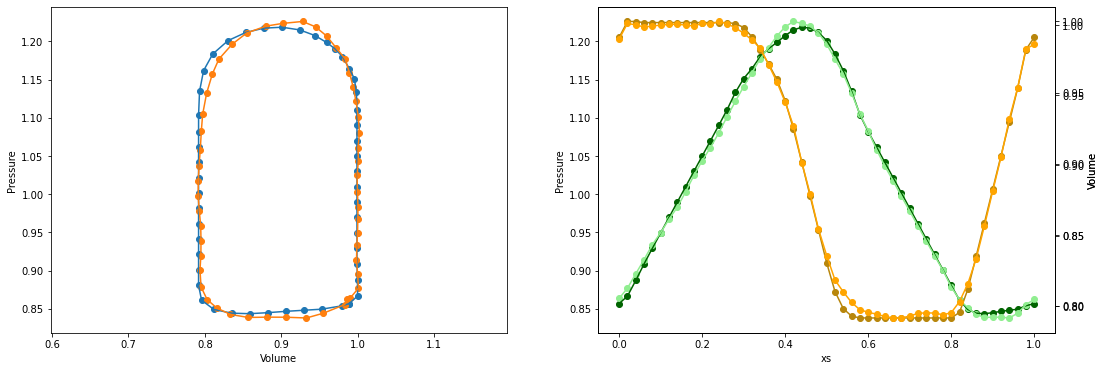

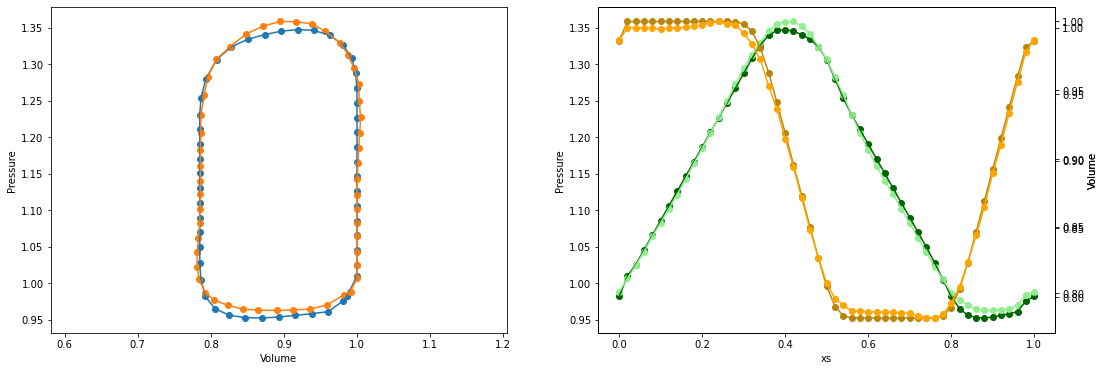

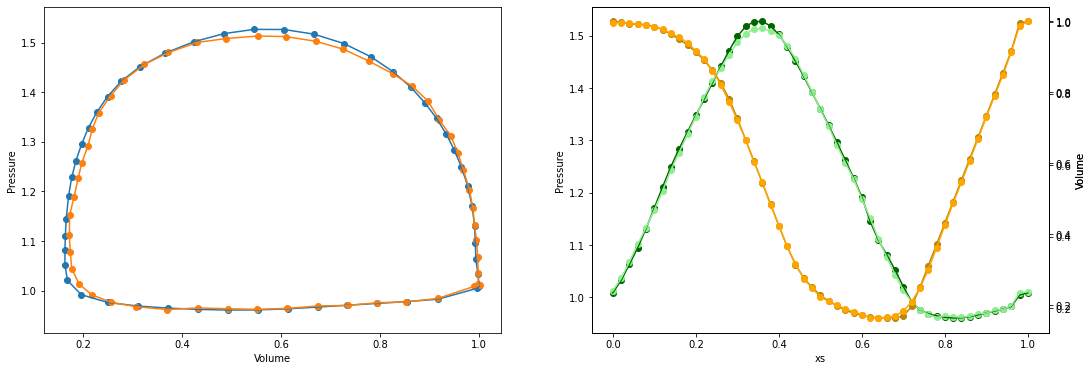

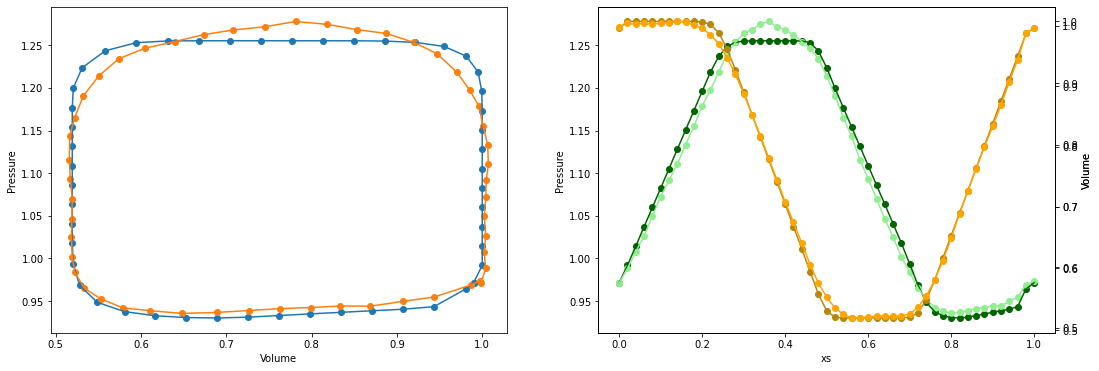

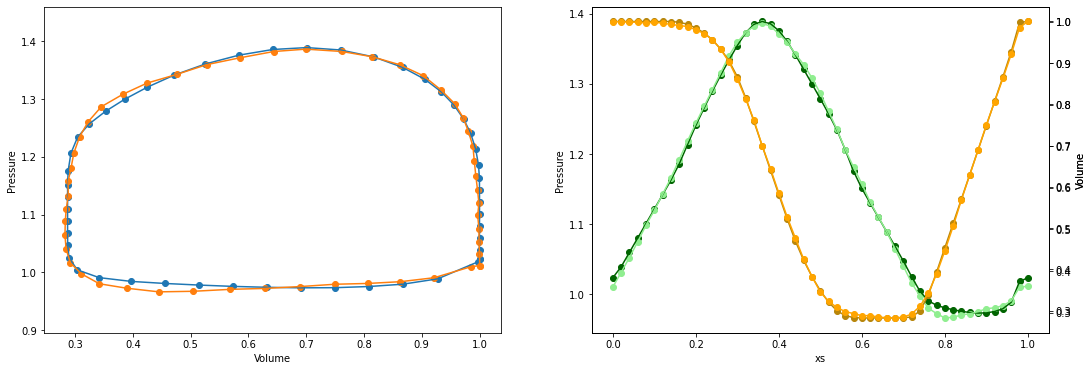

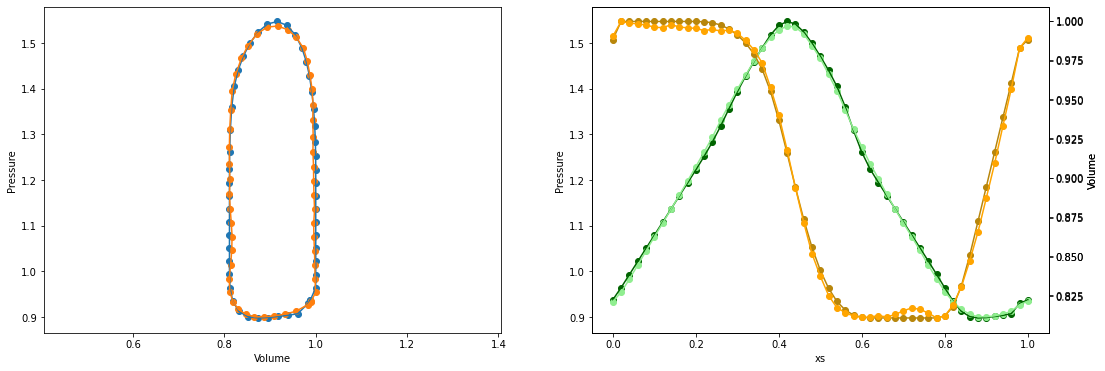

In [46]:
N_BATCHS = 6
N_SAMPLES = 3

for batch_idx, data in enumerate(ds_test.take(N_BATCHS)):
  pv_reconstructions = PV_AUTOENCODER.predict(data[0])
  pv_true = data[0]
  for bidx in range(N_SAMPLES):
    pv_true = data[0][bidx]
    pv_rec = pv_reconstructions[bidx]

    fig, axs = plt.subplots(1, 2, figsize=(18,6))
    PVA.plot_pv(pv=pv_true, ps_color='darkgreen', vs_color='darkgoldenrod',
                    expanded_plot=True, ax=axs, equal=True, legend=False)
    PVA.plot_pv(pv=pv_rec, ps_color='lightgreen', vs_color='orange',
                    expanded_plot=True, ax=axs, equal=True, legend=False)

In [125]:
N_BATCHS = 5
pv_to_save = None
for batch_idx, data in enumerate(ds_test.take(N_BATCHS)):
  pv_reconstructions = np.vstack(PV_AUTOENCODER.predict(data[0]))
  codings = np.repeat(PV_ENCODER.predict(data[0]), 51, axis=0)

  pv_true = np.vstack(data[0])
  idx = np.repeat(np.arange(0,51, dtype=np.int16), 32).reshape((-1,1)) + batch_idx*32
  
  pv_data = np.vstack([list(CardiovascularData(pv).to_dict().values()) for pv in data[0]])
  pv_data = np.repeat(pv_data, 51, axis=0)

  stacked = np.hstack((idx, pv_true, pv_reconstructions, codings, pv_data))
  if pv_to_save is None:
    pv_to_save = stacked
  else:
    pv_to_save = np.vstack((pv_to_save, stacked))

1/1 [==============================] - 0s 19ms/step


In [127]:
cd_keys = CardiovascularData(data[0][0]).to_dict().keys()
cd_keys = [f"cvd:{x}" for x in cd_keys]

In [128]:
codind_keys = [f"coding:{c}" for c in range(N_CODINGS)]

In [129]:
import pandas as pd
df = pd.DataFrame(pv_to_save, columns=["sample", "P_true", "V_true", "P_AE", "V_AE", *codind_keys, *cd_keys])

In [131]:
df

,sample,P_true,V_true,P_AE,V_AE,coding:0,coding:1,coding:2,coding:3,coding:4,...,cvd:SSP,cvd:ESV,cvd:ESP,cvd:SV,cvd:SW,cvd:CO,cvd:CR,cvd:Ea,cvd:Ees,cvd:EF
0,0.0,0.849064,0.987885,0.874444,0.989633,0.001129,0.007592,-0.004382,-0.007378,-0.004589,...,0.865085,0.795321,1.157626,0.192564,1.132782,-1.0,0.242121,6.011646,1.455546,19.492546
1,0.0,0.872557,1.000000,0.893038,1.002765,0.001129,0.007592,-0.004382,-0.007378,-0.004589,...,0.865085,0.795321,1.157626,0.192564,1.132782,-1.0,0.242121,6.011646,1.455546,19.492546
2,0.0,0.901425,1.000000,0.920457,0.999673,0.001129,0.007592,-0.004382,-0.007378,-0.004589,...,0.865085,0.795321,1.157626,0.192564,1.132782,-1.0,0.242121,6.011646,1.455546,19.492546
3,0.0,0.931307,1.000000,0.947067,0.999028,0.001129,0.007592,-0.004382,-0.007378,-0.004589,...,0.865085,0.795321,1.157626,0.192564,1.132782,-1.0,0.242121,6.011646,1.455546,19.492546
4,0.0,0.961349,1.000000,0.975498,1.001590,0.001129,0.007592,-0.004382,-0.007378,-0.004589,...,0.865085,0.795321,1.157626,0.192564,1.132782,-1.0,0.242121,6.011646,1.455546,19.492546
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8155,178.0,0.901655,0.930970,0.894463,0.932769,-0.002466,0.000479,0.004177,-0.001022,-0.002037,...,0.918900,0.820552,1.164154,0.179448,0.879803,-1.0,0.218693,6.487401,1.418746,17.944849
8156,178.0,0.903009,0.947377,0.897698,0.950658,-0.002466,0.000479,0.004177,-0.001022,-0.002037,...,0.918900,0.820552,1.164154,0.179448,0.879803,-1.0,0.218693,6.487401,1.418746,17.944849
8157,178.0,0.904538,0.963922,0.902131,0.965107,-0.002466,0.000479,0.004177,-0.001022,-0.002037,...,0.918900,0.820552,1.164154,0.179448,0.879803,-1.0,0.218693,6.487401,1.418746,17.944849
8158,178.0,0.913402,0.985572,0.913663,0.984184,-0.002466,0.000479,0.004177,-0.001022,-0.002037,...,0.918900,0.820552,1.164154,0.179448,0.879803,-1.0,0.218693,6.487401,1.418746,17.944849


# save

In [137]:
MODEL_PREFIX = "PV_AUTOENCODER"

PV_AUTOENCODER.save(model_save_root/MODEL_PREFIX.upper()/"best")
PV_AUTOENCODER.save_weights(model_save_root/MODEL_PREFIX.upper()/"best"/"weigths")

In [140]:
df.to_csv(model_save_root/MODEL_PREFIX.upper()/"pv_reconstructions.csv", index=False)

In [139]:
MODEL_PREFIX = "PV_ENCODER"

PV_ENCODER.save(model_save_root/MODEL_PREFIX.upper()/"best")
PV_ENCODER.save_weights(model_save_root/MODEL_PREFIX.upper()/"best"/"weigths")